# Ensemble Kalman Filter (アンサンブルカルマンフィルター)

## ----------コードを書く前の下準備----------

### Reference (参考文献)
- 樋口知之編著，上野玄太・中野慎也・中村和幸・吉田亮著，データ同化入門ー次世代のシミュレーション技術ー，朝倉書店，2011．

### Ensemble Kalman Filter (アンサンブルカルマンフィルター)

特徴
- KFでは，平均・共分散行列だけ更新していたが，EnKFでは，アンサンブルメンバー(状態サンプルを幾つも用意しモンテカルロ近似を行う)の更新を考える．
- EnKFでは，非線形・非ガウスにも対応することができる．

対象とする状態空間モデルは，
$$
\begin{align}
x_t=f_t(x_{t-1},v_t),\ v_t\sim q(v_t)\\
y_t=H_tx_t+w_t,\ w_t\sim N(0,R_t)
\end{align}
$$
である．観測モデルに関してはガウス・線形性を仮定するが，非線形の場合でも適切な前処理をすれば適用可能である．

アルゴリズム
1. 初期状態のアンサンブル$\{x_{0|0}^{(i)}\}_{i=1}^N$を生成する．
2. $t=1:T$まで以下を繰り返す．
    1. 一期先予測
        1. システムノイズのアンサンブル$\{v_t^{(i)}\}_{i=1}^N$を$q(v_t)$に従って生成する．
        1. 各アンサンブルメンバーに対して，$x_{t|t-1}^{(i)}=f_t(x_{t-1|t-1}^{(i)},v_t)$を計算する．
    1. フィルタ
        1. 観測ノイズのアンサンブル$\{w_t^{(i)}\}_{i=1}^N$を$N(0,R_t)$に従って生成する．
        1. 共分散行列$\hat V_{t|t-1}$，カルマンゲイン$\hat K_t$を後述する式で計算する．
        1. 各アンサンブルメンバーに対して，$x_{t|t}^{(i)}=x_{t|t-1}^{(i)}+\hat K_t(y_t+\breve w_t^{(i)}-H_tx_{t|t-1}^{(i)})$を計算し，フィルタアンサンブル$\{x_{t|t}^{(i)}\}_{i=1}^N$を得る．

フィルタB.bの計算式は以下の通りである．
$$
\begin{align}
\breve x_{t|t-1}^{(i)}=x_{t|t-1}^{(i)}-\frac{1}{N}\sum_{j=1}^Nx_{t|t-1}^{(j)}\\
\hat V_{t|t-1}=\frac{1}{N-1}\sum_{j=1}^N\breve x_{t|t-1}^{(j)}\breve x_{t|t-1}^{(j)}{}^T\\
\breve w_t^{(i)}=w_t^{(i)}-\frac{1}{N}\sum_{j=1}^Nw_t^{(i)}\\
\hat R_t=\frac{1}{N-1}\sum_{j=1}^N\breve w_t^{(j)}\breve w_t^{(j)}{}^T
\end{align}
$$

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > phase2 > Python_source : saving place for source
- DataAssimilation > phase2 > plot : saving place for plot result

バージョンについて
- Mac OS 10.13
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1

In [1]:
# install packages
from IPython.core.display import display
import time
import math

import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE

from ensemble import *

## Lorenz63 で試してみた

In [2]:
# update
def Lorenz_update(state, param, dt) :
    u = state[0]
    v = state[1]
    w = state[2]
    p = param[0]
    r = param[1]
    b = param[2]
    new_state = np.zeros_like(state)
    new_state[0] = u + dt * p * (- u + v)
    new_state[1] = v + dt * (- u*w + r*u - v)
    new_state[2] = w + dt * (u*v - b*w)
    return new_state

# perfect simulation function
def Lorenz_perfect(initial, param, time, dt) :
    t = 0
    state = initial
    l = math.ceil(time / dt) + 1
    u = np.zeros(l + 1)
    v = np.zeros(l + 1)
    w = np.zeros(l + 1)
    u[0] = initial[0]
    v[0] = initial[1]
    w[0] = initial[2]
    for i in range(l) :
        state = Lorenz_update(state, param, dt)
        u[i + 1] = state[0]
        v[i + 1] = state[1]
        w[i + 1] = state[2]
    return u, v, w

def Lorenz_perfect_noise(initial, param, time, dt, sigma) :
    t = 0
    state = initial
    l = math.ceil(time / dt) + 1
    u = np.zeros(l + 1)
    v = np.zeros(l + 1)
    w = np.zeros(l + 1)
    u[0] = initial[0]
    v[0] = initial[1]
    w[0] = initial[2]
    for i in range(l) :
        noise = rd.normal(0, sigma, size = 3)
        state = Lorenz_update(state, param, dt) + noise
        u[i + 1] = state[0]
        v[i + 1] = state[1]
        w[i + 1] = state[2]
    return u, v, w

# initial particle
def Initial_particle(mu_0, initial_sd, n_particle) :
    return rd.normal(mu_0, initial_sd, size = n_particle)

In [3]:
# parameter
#a = -2
#b = -1
n_dim = 3
n_particle = 10**2
# sys_sigma, obs_sigma are variance
sys_sigma = 3
obs_sigma = 2.615
# make sigma is standard deviation
make_sigma = 0.1
initial = np.array([5.0, 5.0, 5.0])
mu_0 = np.array([4.5, 5.5, 5.5])
initial_sd = 0.01
param = np.array([10, 28, 8 / 3])
dt = 0.01
end_time = 15.0

In [4]:
# perfect simulation
perf_u, perf_v, perf_w = Lorenz_perfect(initial, param, end_time, dt)
# perfect simulation + noise
perf_u_noise, perf_v_noise, perf_w_noise = Lorenz_perfect_noise(initial,
                                                                param, end_time, dt, make_sigma)

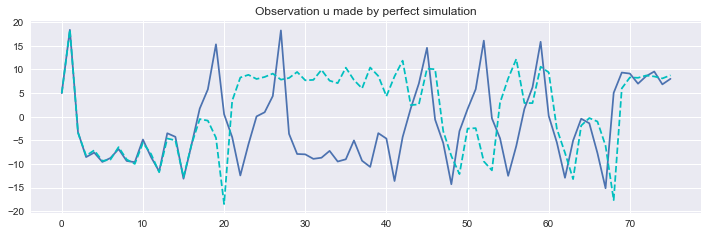

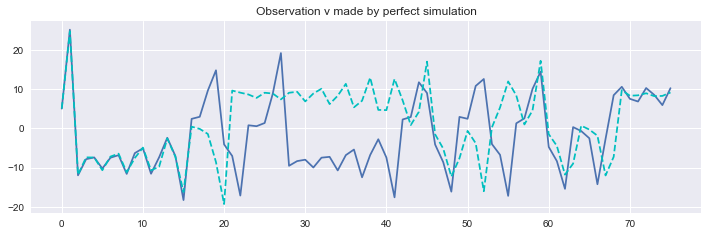

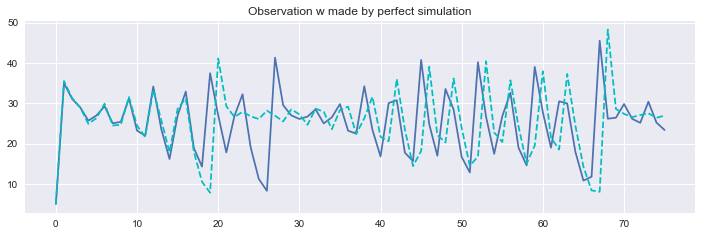

In [5]:
# plot observation from perfect simulation data
time_interval = 20
time_step = math.ceil(end_time / dt) + 1
time_data = np.linspace(0, end_time, time_step)
obs_u = np.zeros(time_step)
obs_v = np.zeros(time_step)
obs_w = np.zeros(time_step)
obs_u[:] = np.nan
obs_v[:] = np.nan
obs_w[:] = np.nan
obs_u[::time_interval] = perf_u_noise[::time_interval]
obs_v[::time_interval] = perf_v_noise[::time_interval]
obs_w[::time_interval] = perf_w_noise[::time_interval]

plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 1)
plt.plot(obs_u[::time_interval], label = 'obs_u')
plt.plot(perf_u[::time_interval], linestyle = '--', color = 'c', label = 'perf_u')
plt.title("Observation u made by perfect simulation")

plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 2)
plt.plot(obs_v[::time_interval], label = 'obs_v')
plt.plot(perf_v[::time_interval], linestyle = '--', color = 'c', label = 'perf_v')
plt.title("Observation v made by perfect simulation")

plt.figure(figsize = (12, 12))
plt.subplot(3, 1, 3)
plt.plot(obs_w[::time_interval], label = 'obs_w')
plt.plot(perf_w[::time_interval], linestyle = '--', color = 'c', label = 'perf_w')
plt.title("Observation w made by perfect simulation")

plt.show()

In [6]:
print(obs_u)

[5.                nan        nan ...        nan        nan 8.03128789]


In [7]:
y = np.c_[obs_u, obs_v, obs_w]
y.shape

(1501, 3)

In [8]:
y[:5]

array([[ 5.,  5.,  5.],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [9]:
def transition_function(state, noise):
    param = np.array([10, 28, 8 / 3])
    dt = 0.01
    
    u = state[0]
    v = state[1]
    w = state[2]
    p = param[0]
    r = param[1]
    b = param[2]
    new_state = np.zeros_like(state)
    new_state[0] = u + dt * p * (- u + v)
    new_state[1] = v + dt * (- u*w + r*u - v)
    new_state[2] = w + dt * (u*v - b*w)
    return new_state + noise

In [10]:
'''
ekf = Ensemble_Kalman_Filter(y[:200], transition_functions = [transition_function],  initial_mean = initial , 
                             n_dim_sys = 3, n_dim_obs = 3, n_particle = 10,
                             transition_noise = (rd.multivariate_normal, [np.zeros(3), sys_sigma**2 * np.eye(3)]),
                            observation_covariance = obs_sigma * np.eye(3))
ekf.filter()
'''

'\nekf = Ensemble_Kalman_Filter(y[:200], transition_functions = [transition_function],  initial_mean = initial , \n                             n_dim_sys = 3, n_dim_obs = 3, n_particle = 10,\n                             transition_noise = (rd.multivariate_normal, [np.zeros(3), sys_sigma**2 * np.eye(3)]),\n                            observation_covariance = obs_sigma * np.eye(3))\nekf.filter()\n'

- Z[t]の列和が1になっているので，Z[t]におけるプログラミングミスはなさげ 

In [11]:
y = y.astype(np.float16)

In [13]:
st = time.time()
ekf = Ensemble_Kalman_Filter(y, transition_functions = [transition_function],  initial_mean = initial , 
                             n_dim_sys = 3, n_dim_obs = 3, n_particle = 50,
                             transition_noise = (rd.multivariate_normal, [np.zeros(3), sys_sigma**2 * np.eye(3)]),
                            observation_covariance = obs_sigma * np.eye(3), dtype = np.float16)
ekf.filter()
ekf.smooth(lag = 100)
print(time.time() - st)

 smooth calculating... t=1502/150119.948396921157837


実験記録
- 0313
    - y[:200], n_particle = 50, lag = 20, time_interval = 20
        - time : 83.93[sec]
- 0315
    - y[:200], n_particle = 50, lag = 20, time_interval = 20
        - time 3.49[sec]
        - コードリファクタで大分速くなった
    - y[:200], n_particle = 50, lag = 20, time_interval = 2
        - time 3.86 [sec]
    - y[:1500], n_particle = 50, lag = 100, time_interval = 20, make_sigma = 0.5
        - time 22.36 [sec]
- 0317
    - time 20.27, 21.14, 22.56 [sec]
- 0322
    - evansen : 42.82 [sec] (粒子次元<観測次元で威力を発揮するため)
    - rd size restrict : 20.33 [sec]
    - truncatedSVD : 20.89 [sec]
    - pypropack : 19.70 [sec]

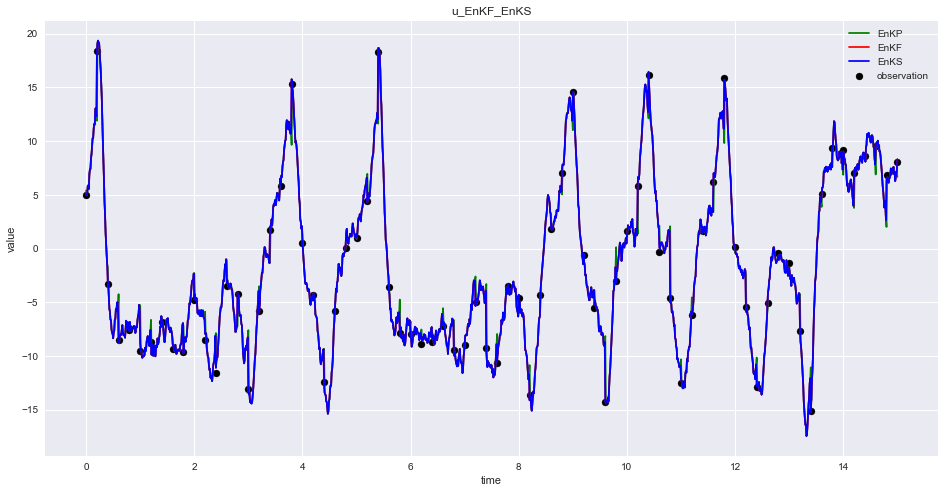

In [14]:
T = len(obs_u)
        
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], color = "k",
            marker = 'o', label = "observation")
plt.plot(time_data, ekf.get_predicted_value(0), color = "g", label = "EnKP")
plt.plot(time_data, ekf.get_filtered_value(0), color = "r", label = "EnKF")
plt.plot(time_data, ekf.get_smoothed_value(0), color = "b", label = "EnKS")
        
#for t in range(T):
#    plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2, alpha = 0.1)
        
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_EnKF_EnKS")
#plt.savefig("../plot/180329_twin_experiment_EnKF.png")
plt.show()

- lag 500 取ったが，あまり平滑化されている気配は感じられない
    - 粒子数が足りないせいか，コーディングミスか，固定ラグ平滑化のせいか
- smoothing されていないのは，各時刻に観測があることを前提とした smoothing の式であるからかもしれない

## 通常の時系列で試してみた

In [13]:
df = pd.read_csv('../../data/rhine-river-near-basle-switzerla.csv')

In [14]:
df.head()

,Year,Data
0,1807,864.884
1,1808,1033.141
2,1809,826.923
3,1810,1018.777
4,1811,1118.296


In [15]:
y = np.array(df['Data'])

In [16]:
y /= 1000

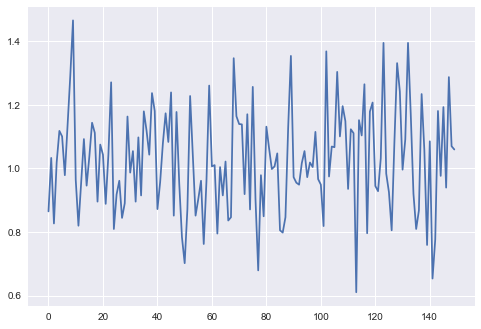

In [17]:
plt.plot(y)

In [18]:
len(y)

150

In [19]:
ekf = Ensemble_Kalman_Filter(y, initial_mean = [0.8] , n_dim_sys = 1, n_dim_obs = 1)
ekf.smooth(lag = 80)

 smooth calculating... t=150/150

In [19]:
#ekf2 = Ensemble_Kalman_Filter(y, transition_functions = [lambda x,v : 0.9*x+v],  initial_mean = [0.8] , n_dim_sys = 1, n_dim_obs = 1)
#ekf2.filter()

 filter calculating... t=149/150

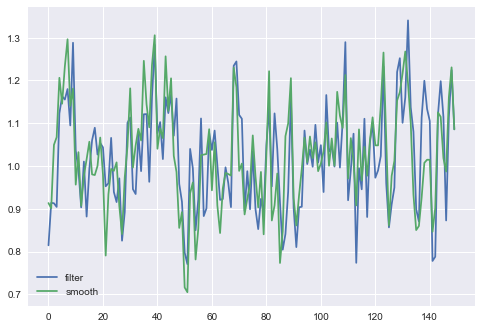

In [20]:
#plt.plot(ekf.get_predicted_value(), label = 'predict')
plt.plot(ekf.get_filtered_value(), label = 'filter')
plt.plot(ekf.get_smoothed_value(), label = 'smooth')
#plt.plot(ekf2.get_filtered_value(), label = 'AR')
#plt.plot(y, label = 'obs')
plt.legend(loc = 'best')

- 状態遷移関数 x+v というランダムウォークな適当な設定なのでまあこんなもん笑
- smooth 感がほんとに感じられない〜

In [11]:
len(np.asarray(ekf.f).shape)

0

色々と改善方針

- カルマンゲイン計算しているのをやめて，Zを計算するように変更？

ノイズ発生計算用

In [7]:
# multivariate_normla は同時に多数発生させられる
rd.multivariate_normal(np.zeros(2), np.eye(2), size = 5)

array([[ 1.41791347,  1.74758099],
       [ 0.48678787,  1.40741448],
       [ 0.01112654,  0.75523378],
       [ 0.08412188, -0.34736737],
       [-0.94864026, -0.65311415]])

enkf の計算簡略用

In [15]:
a = np.arange(1,3)
b = 0.1 * np.arange(1,3)
a * b

array([0.1, 0.4])

In [36]:
np.transpose([a, b], (0,2,1))

array([[[0. , 2. ],
        [1. , 3. ]],

       [[0. , 0.2],
        [0.1, 0.3]]])

In [33]:
np.array([a, b]).transpose(0, 2, 1)

array([[[0. , 2. ],
        [1. , 3. ]],

       [[0. , 0.2],
        [0.1, 0.3]]])

In [31]:
np.concatenate((a, b), axis = 1)

array([[0. , 1. , 0. , 0.1],
       [2. , 3. , 0.2, 0.3]])

In [34]:
def func(a, b):
    return a[1] + b[0]

a = np.arange(4).reshape(2, 2)
b = 0.1 * np.arange(4).reshape(2, 2)
print(func(a[0], b[0]), func(a[1], b[1]))
func(*np.array([a, b]).transpose(0, 2, 1))

1.0 3.2


array([1. , 3.2])

In [22]:
def func(a) : return a+10
len(np.asarray([func]).shape)

1

In [13]:
def func(a) : return a+10
a = np.array([1,2,3])
b = map(func, a)
np.array(list(b))

array([11, 12, 13])

In [21]:
def func(a) : return a+10
vfunc = np.vectorize(func)
a = np.array([1,2,3])
vfunc(a)

array([11, 12, 13])

In [72]:
def func2(a,b) : return a[0]+b[0]
vfunc2 = np.vectorize(func2, signature = '(m,n),(m,n)->(n)')
a = np.array([[1,2,3], [4,5,6]])
b = np.array([[0.1,0.2,0.3], [0.4,0.5,0.6]])
vfunc2(a,b)

array([ 1.1,  2.2,  3.3])

x_pred_mean 計算に際して確認

In [3]:
a = np.arange(1, 4)
1/a

array([1.        , 0.5       , 0.33333333])

In [23]:
a = np.array([[1,2], [3,4]])
np.mean(a)

2.5

In [25]:
np.mean(a, axis = 0), np.mean(a, axis = 1)

(array([ 2.,  3.]), array([ 1.5,  3.5]))

In [26]:
b = np.array([0.1, 0.2])
a-b

array([[ 0.9,  1.8],
       [ 2.9,  3.8]])

In [37]:
np.kron(a, a)

array([[ 1,  2,  2,  4],
       [ 3,  4,  6,  8],
       [ 3,  6,  4,  8],
       [ 9, 12, 12, 16]])

In [38]:
np.vdot(a,a)

30

In [27]:
np.outer(a,a)

array([[ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12],
       [ 4,  8, 12, 16]])

In [30]:
a

array([[1, 2],
       [3, 4]])

In [29]:
vouter = np.vectorize(np.outer)
vouter(a, a)

array([[ 1,  4],
       [ 9, 16]])

In [34]:
np.tensordot(a, a, axes=1)

array([[ 7, 10],
       [15, 22]])

In [8]:
q[1]

[0, 1]

In [21]:
def func(a, b):
    return a+b
q = (func, [4,1])
q[0](*q[1])

5

なんか計算用

In [23]:
a = np.zeros((2,3,4))
a[0] = range(4)
a

array([[[ 0.,  1.,  2.,  3.],
        [ 0.,  1.,  2.,  3.],
        [ 0.,  1.,  2.,  3.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

In [28]:
a = np.array([[1,2],[3,4]])
b = 0.1 * a
display(a)
np.dot(a, b)

array([[1, 2],
       [3, 4]])

array([[0.7, 1. ],
       [1.5, 2.2]])

dtypeが合ってないと割とうまくいかなかったりする

In [59]:
a = np.arange(10).reshape(2,5)
display(a)
a.T[:] += np.arange(10).reshape(5,2)
a

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

array([[ 0,  3,  6,  9, 12],
       [ 6,  9, 12, 15, 18]])

In [44]:
a = np.arange(10).reshape(2,5)
a.T[:] = np.zeros(2)
a

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])